<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/train_softmax_wavefilter_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip uninstall -y wavefilter
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Found existing installation: wavefilter 0.0.1
Uninstalling wavefilter-0.0.1:
  Successfully uninstalled wavefilter-0.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-6uosnkdt/wavefilter_d1ec285c69904427919a9491320facae
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-6uosnkdt/wavefilter_d1ec285c69904427919a9491320facae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=8628 sha256=c8b9db09d21e88653207cf943f41748a675ccf261cb54d5b2c2acd1e066860c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-3lksn8ac/wheels/90/df/9f/9270370fe3646030b374f3d85d149fae54db3182db8119bb26
Successfully built wavefilter


In [10]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import wavefilter.models as models
from wavefilter.evaluate import split_parameters, train_parallel_pulse_finder, CaptureActivations
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Make some data

In [12]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wds.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data

array([[-0.01212477,  0.8816586 , -0.2664224 , ..., -0.44360813,
        -0.93709743,  0.36960676],
       [ 0.73344   ,  3.921197  , -0.822513  , ...,  0.9672229 ,
        -0.15284637,  0.31420493],
       [-1.24189   , -1.8403411 , -0.24496387, ..., -2.6501896 ,
        -3.5674434 ,  0.79342943],
       ...,
       [-3.7355616 , -2.8744626 ,  1.2083267 , ..., -3.3315234 ,
        -4.3296933 , -3.1684918 ],
       [-1.2040932 ,  2.3184628 ,  0.6737381 , ...,  3.6919653 ,
        -1.8350091 ,  1.7696522 ],
       [ 0.90502155,  2.3189664 ,  1.9105866 , ...,  0.9913179 ,
        -0.2557725 , -1.9887278 ]], dtype=float32)

In [13]:
ds = wds.to_torch_dataset(data)
train_loader = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f858e0b48f0>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f858e0a5a10>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f858e0b4a10>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f858e0a59b0>)]


## Set up the model

In [26]:
model = models.WaveFilter(200, models.GlobalSoftMaxAttention()).to(device)
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): GlobalSoftMaxAttention()
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


In [27]:
lr_schedules = [lambda x: 1]
tester = train_parallel_pulse_finder(train_loader, model, param_groups=model.parameters(), lr_schedules=lr_schedules, device=device, epochs=100)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

AttributeError: ignored

## Inspect what we've learnt

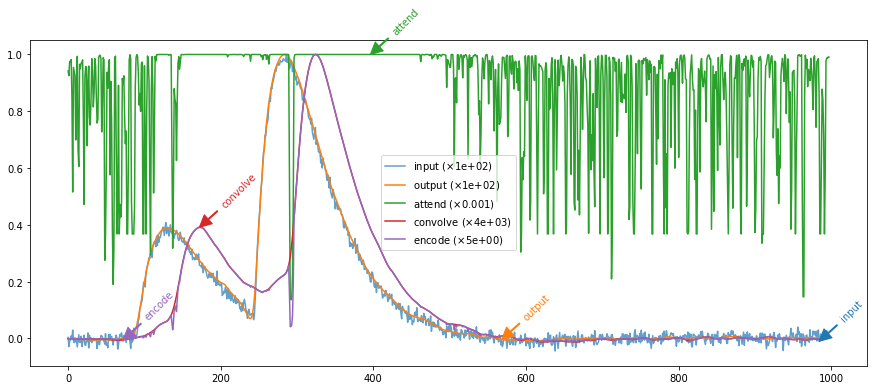

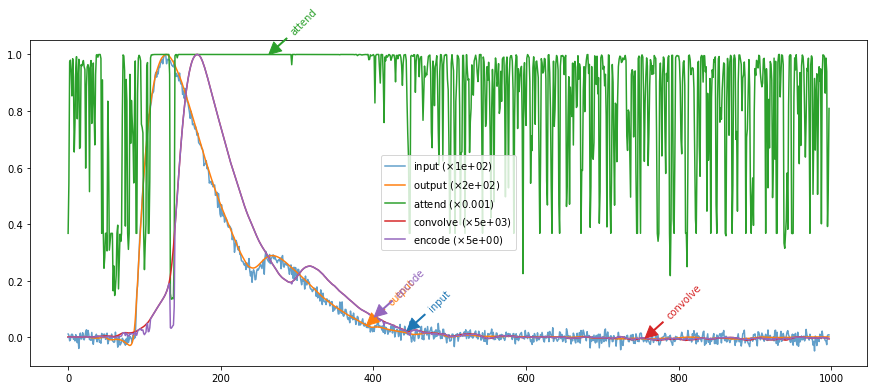

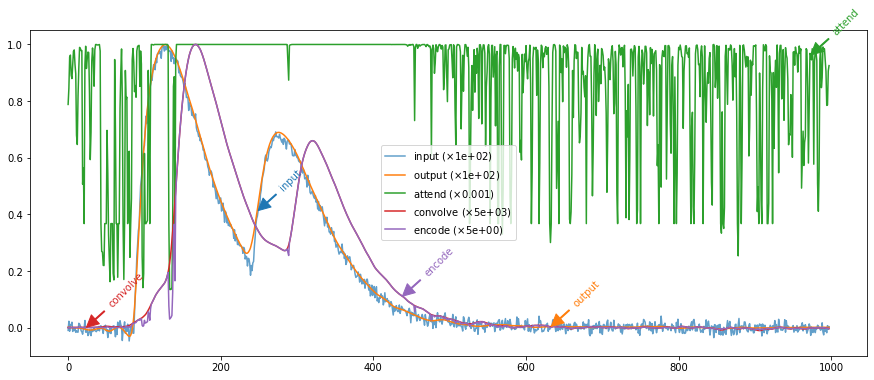

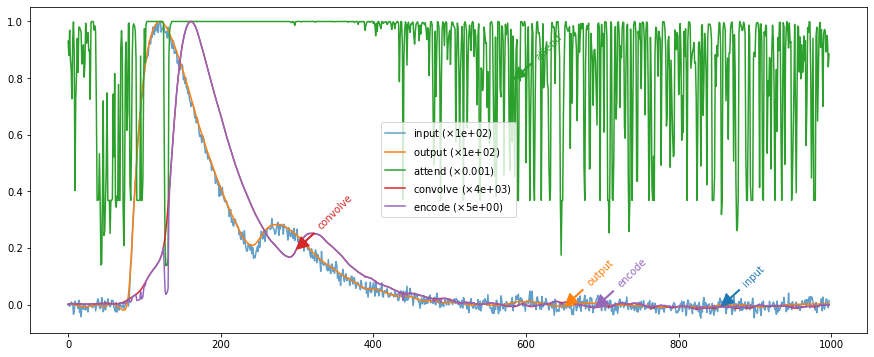

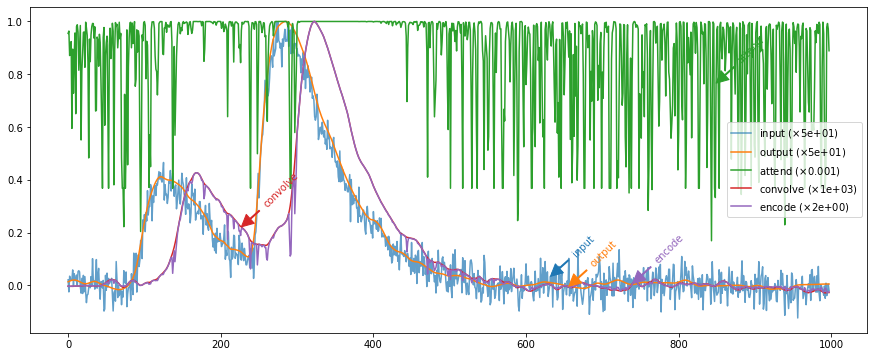

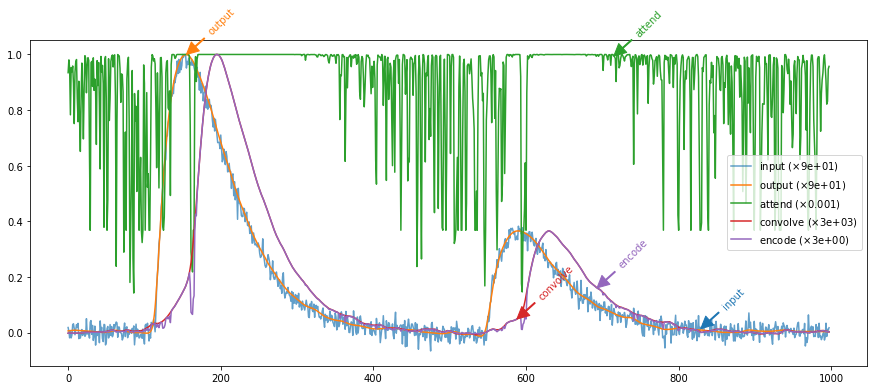

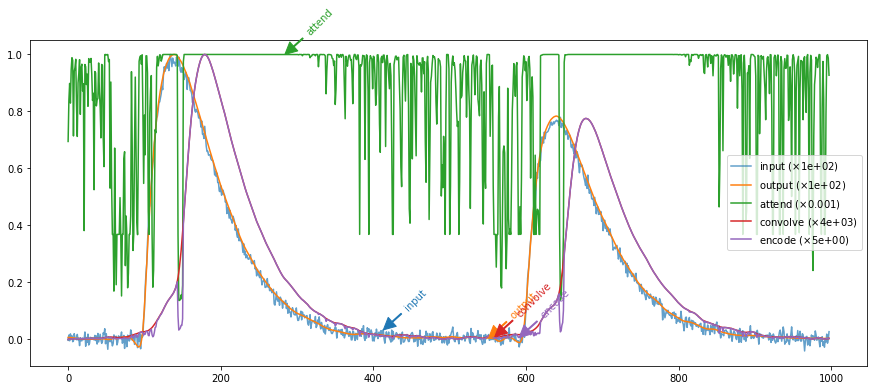

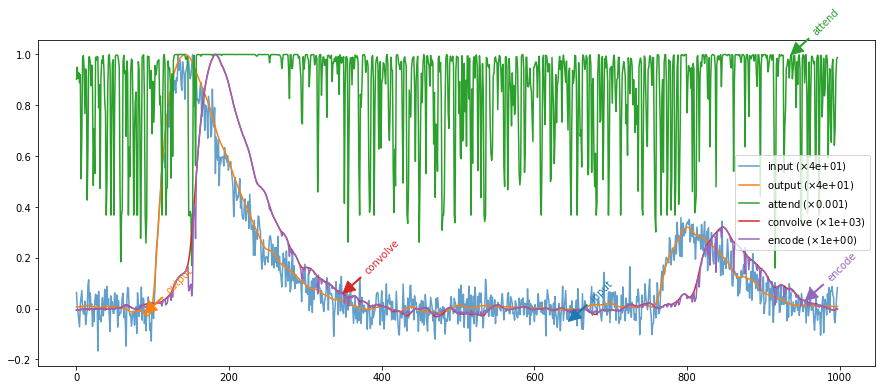

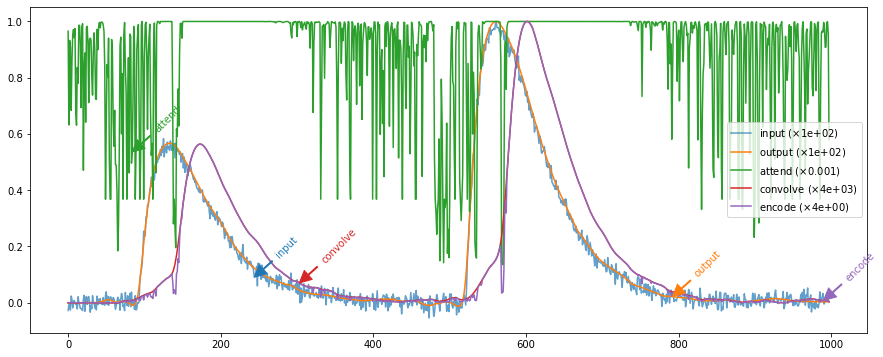

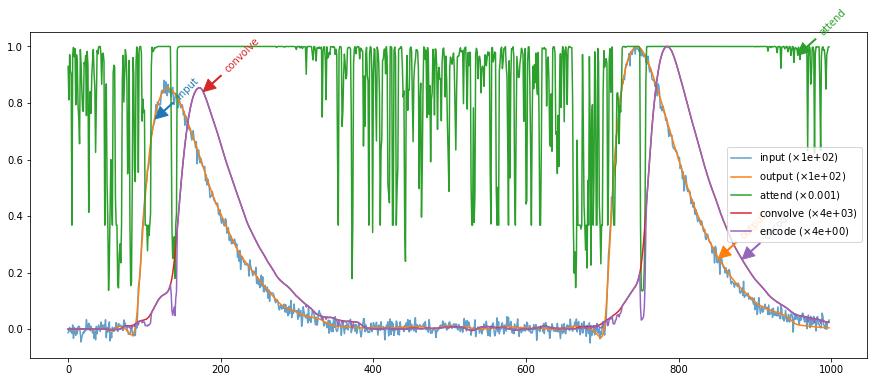

In [21]:
activations = CaptureActivations()
activations.register(model, "attend", "encode", "convolve", "reconstruct")

def plot_line(data, label, **kwargs):
  scale = max(data.max(), -data.min())
  lines = plt.plot(data / scale, label=f"{label} ($\\times${scale:.01})", **kwargs)
  x = np.random.randint(len(data))
  y = data[x] / scale
  color = lines[0].get_color()
  plt.annotate(label, (x,y), xycoords="data", textcoords="offset points", xytext=(20,20), arrowprops=dict(width=1, color=color), color=color , rotation=45)
  

def plot_prediction(model, input):
  output = model(input.to(device))
  plot_line(input[0], label="input", alpha=0.7)
  plot_line(output[0].detach().cpu().numpy(), label="output")
  for i in ['attend', 'convolve' , 'encode']:
    plot_line(activations[i][0].cpu(), label=i)
  plt.legend()
  #plt.yscale("log")

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
for i in choices: #np.random.randint(len(data), size=10):
  plt.figure(figsize=(15,6))
  plot_prediction(model, ds[i][0])

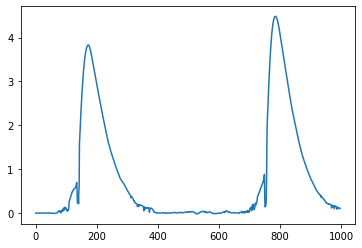

In [22]:
plt.plot(activations["encode"][0].cpu().numpy())

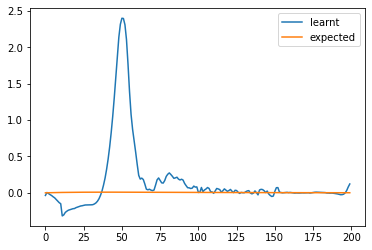

In [23]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt, label="learnt")
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected, label="expected")
plt.legend()

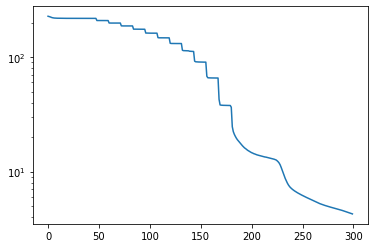

In [24]:
plt.plot(tester.train_loss);
plt.yscale("log")

In [25]:
for name, param in model.named_parameters():
  print(f"{name} = {param}")
  print()

convolve.weight = Parameter containing:
tensor([[[-3.6178e-02,  4.5065e-03, -1.0042e-02, -2.4527e-02, -3.6794e-02,
          -5.3974e-02, -6.8424e-02, -9.0735e-02, -1.1491e-01, -1.3505e-01,
          -1.5018e-01, -3.1761e-01, -3.0348e-01, -2.6952e-01, -2.5292e-01,
          -2.3922e-01, -2.3213e-01, -2.2522e-01, -2.1862e-01, -2.1602e-01,
          -2.0390e-01, -1.9697e-01, -1.8904e-01, -1.8124e-01, -1.7800e-01,
          -1.7201e-01, -1.6759e-01, -1.6734e-01, -1.6716e-01, -1.6727e-01,
          -1.6508e-01, -1.6298e-01, -1.5371e-01, -1.3953e-01, -1.1664e-01,
          -8.3264e-02, -3.5349e-02,  2.5264e-02,  1.0681e-01,  2.0248e-01,
           3.2224e-01,  4.6351e-01,  6.3023e-01,  8.2614e-01,  1.0499e+00,
           1.3035e+00,  1.5879e+00,  1.8800e+00,  2.1367e+00,  2.3156e+00,
           2.3987e+00,  2.3953e+00,  2.3090e+00,  2.1060e+00,  1.7685e+00,
           1.3878e+00,  1.0769e+00,  8.7171e-01,  7.1634e-01,  5.5897e-01,
           3.9270e-01,  2.3983e-01,  1.8832e-01,  2.0168e-01